In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


In [31]:
(x_train, _),(x_test, _)=mnist.load_data()
x_train=x_train.astype("float32")/255.
x_test=x_test.astype("float32")/255.
x_train=np.expand_dims(x_train,-1)
x_test=np.expand_dims(x_test,-1)

In [32]:
latent_dim = 2
inputs=layers.Input(shape=(28,28,1))
x=layers.Conv2D(32,3,activation="relu",strides=2,padding="same")(inputs)
x=layers.Conv2D(64,3,activation="relu",strides=2,padding="same")(x)
x=layers.Flatten()(x)
x=layers.Dense(64,activation="relu")(x)
z_mean=layers.Dense(latent_dim,name="z_mean")(x)
z_log_var=layers.Dense(latent_dim,name="z_log_var")(x)
encoder=models.Model(inputs,[z_mean, z_log_var],name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 3136)           │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 64)             │        200,768 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            130 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            130 │ dense_29[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 219,844 (858.77 KB)

 Trainable params: 219,844 (858.77 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
latent_inputs=layers.Input(shape=(latent_dim,))
x=layers.Dense(7*7*64,activation="relu")(latent_inputs)
x=layers.Reshape((7,7,64))(x)
x=layers.Conv2DTranspose(64,3,activation="relu",strides=2,padding="same")(x)
x=layers.Conv2DTranspose(32, 3,activation="relu",strides=2,padding="same")(x)
outputs=layers.Conv2DTranspose(1,3,activation="sigmoid",padding="same")(x)
decoder=models.Model(latent_inputs,outputs,name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
class VAE(tf.keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder
    def call(self,inputs):
        z_mean,z_log_var=self.encoder(inputs)
        z=self.reparameterize(z_mean,z_log_var)
        reconstructed=self.decoder(z)
        self.add_loss(self.vae_loss(inputs,reconstructed,z_mean,z_log_var))
        return reconstructed
    def reparameterize(self,z_mean,z_log_var):
        epsilon=tf.random.normal(shape=tf.shape(z_mean))
        return z_mean+tf.exp(0.5*z_log_var)*epsilon
    def vae_loss(self,x,x_reconstructed,z_mean,z_log_var):
        reconstruction_loss=tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x,x_reconstructed),axis=(1,2)))
        kl_loss=-0.5*tf.reduce_mean(
            tf.reduce_sum(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var),axis=1)
        )
        return reconstruction_loss+kl_loss

In [35]:
vae=VAE(encoder,decoder)
dummy_input=np.random.random((1,28,28,1))
vae(dummy_input)

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[0.49970612],
         [0.50041765],
         [0.49973541],
         [0.50035465],
         [0.49966064],
         [0.50090086],
         [0.49975806],
         [0.50031865],
         [0.50030386],
         [0.5002329 ],
         [0.49965072],
         [0.49972612],
         [0.49987882],
         [0.49941844],
         [0.4993278 ],
         [0.5008321 ],
         [0.49959052],
         [0.49998423],
         [0.49934962],
         [0.50055957],
         [0.49926013],
         [0.5000778 ],
         [0.4996056 ],
         [0.5001168 ],
         [0.5002323 ],
         [0.50039756],
         [0.49941498],
         [0.5006155 ]],

        [[0.49950206],
         [0.5001373 ],
         [0.50016665],
         [0.5014889 ],
         [0.49846324],
         [0.49935925],
         [0.50003135],
         [0.50051856],
         [0.49960226],
         [0.5001169 ],
         [0.5011549 ],
         [0.5003514 ],
         [0.4998544 ],

In [37]:
def vae_loss(x,x_reconstructed):
    reconstruction_loss=tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x,x_reconstructed),axis=(1,2)
        )
    )
    kl_loss=-0.5*tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    )
    return reconstruction_loss+kl_loss

vae.compile(optimizer="adam",loss=vae_loss)


In [38]:
vae=VAE(encoder,decoder)
vae.compile(optimizer='adam')
vae.fit(x_train,x_train,epochs=5,batch_size=12,validation_data=(x_test,x_test))

Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 120s 24ms/step - loss: 187.7866 - val_loss: 157.9977
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 129s 21ms/step - loss: 156.5750 - val_loss: 152.8374
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 140s 21ms/step - loss: 152.6162 - val_loss: 151.6393
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - loss: 150.7355 - val_loss: 149.9628
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - loss: 148.7966 - val_loss: 148.8510


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


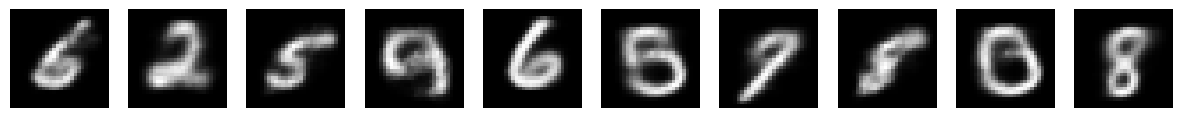

In [39]:
def generate_images(model,num_images=10):
    z_sample = np.random.normal(size=(num_images,latent_dim))
    generated_images=model.decoder.predict(z_sample)
    return generated_images
generated_images=generate_images(vae)
fig,axes=plt.subplots(1,10,figsize=(15,15))
for ax,img in zip(axes,generated_images):
    ax.imshow(img.squeeze(),cmap="gray")
    ax.axis("off")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<ipython-input-43-dbfa0375fa49>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_mean[:, 0],z_mean[:, 1],cmap="viridis")


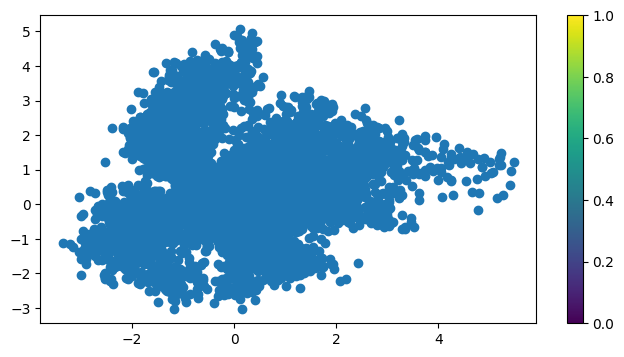

In [43]:
def plot_latent_space(encoder,data):
    z_mean, _=encoder.predict(data)
    plt.figure(figsize=(8,4))
    plt.scatter(z_mean[:, 0],z_mean[:, 1],cmap="viridis")
    plt.colorbar()
    plt.show()
plot_latent_space(encoder, x_test)